<a href="https://colab.research.google.com/github/gabrie1-s/cnn-1d/blob/combined_approaches/cnn_1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
from pathlib import Path
import scipy.io
from glob import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import pandas as pd
from sklearn.preprocessing import normalize, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.stats import zscore

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


#1. Aquisição dos Dados

In [ ]:
data = Path('drive/MyDrive/CNN_Chagas/Physionet/cnn-1d/data')

signals = []
classes =[]

for value in sorted(data.glob('*.mat')):
  signal = scipy.io.loadmat(value)
  signal = np.array(signal["val"], dtype='float')[0]
  signals.append(signal)
  # print(value)

In [ ]:
classification_path = os.path.join(data, "classification.txt")
with open(classification_path) as f:
    classes = f.readlines()

for i in range(0, len(classes)):
  classes[i] = classes[i][classes[i].find(','):]
  classes[i] = classes[i][: classes[i].find('\n')]
  classes[i] = classes[i].replace(",", "")

# classes = classes[0: -1]

#2. Preprocessamento

### 2.1 Análise da distribuição das classes

In [ ]:
d = {'signals': signals, 'classes': classes}
df = pd.DataFrame(data=d)
a = df.groupby('classes')

In [ ]:
for i in ['N', 'O', 'A', '~']:
  print(i)
  aux = []

  for j in a.get_group(i)["signals"]:
    aux.append(len(j))

  print('Média:', round(np.mean(aux), 2))
  print("Std:", round(np.std(aux), 2))
  print("Qntd:", len(aux))
  print("Min:", min(aux))
  print("---------------")

N
Média: 9633.38
Std: 2991.84
Qntd: 5076
Min: 2714
---------------
O
Média: 10288.52
Std: 3528.74
Qntd: 2415
Min: 2738
---------------
A
Média: 9703.41
Std: 3694.64
Qntd: 758
Min: 2996
---------------
~
Média: 7313.63
Std: 3122.42
Qntd: 279
Min: 2808
---------------


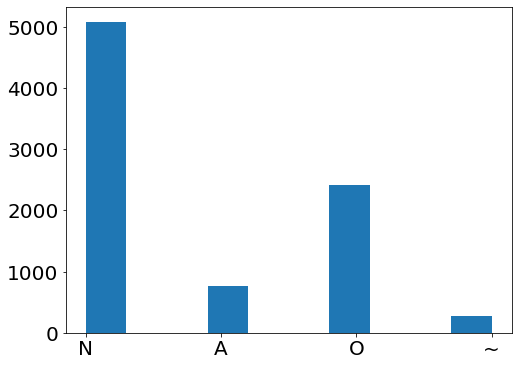

In [ ]:
plt.rcParams.update({'font.size': 20})

df["classes"].hist(
    figsize=(8, 6),
    grid = False,
    bins = 10,
)
plt.xticks(range(4))
# plt.savefig('init_distri.png')
plt.show()

### 2.3 Wavelet helping functions

In [ ]:
def gera_filtro_MH(Escala):
  passo = 1/Escala;
  X = []
  a = -5
  X.append(a)
  while a <= 5:
    a=a+passo
    X.append(a)
  Y = []
  for i in range(0,len(X)):
    Y.append(2.1741*(1/math.sqrt(2*math.pi) * (1 - X[i]**2) * np.exp(-X[i]**2/(2))))
  return Y

In [ ]:
def apply_wavelet(signal, level):
  Filtro = gera_filtro_MH(level)
  y = np.convolve(signal,Filtro)
  return y

###2.4 Aplicação da tranformada Wavelet

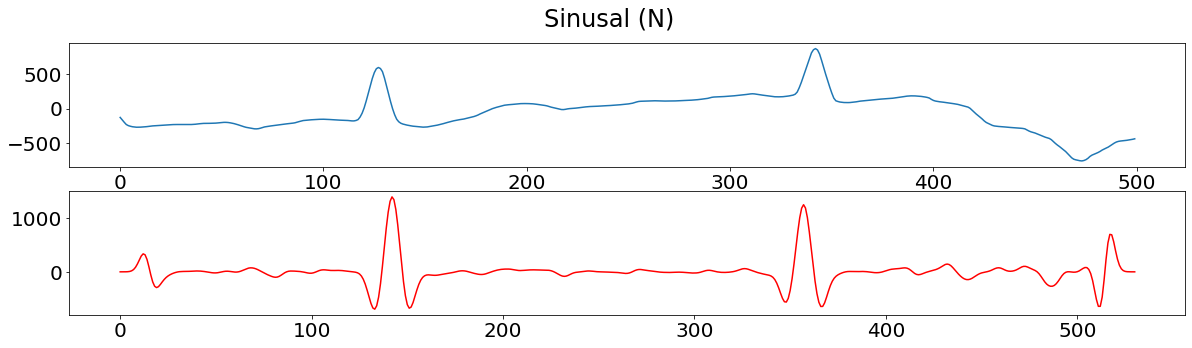

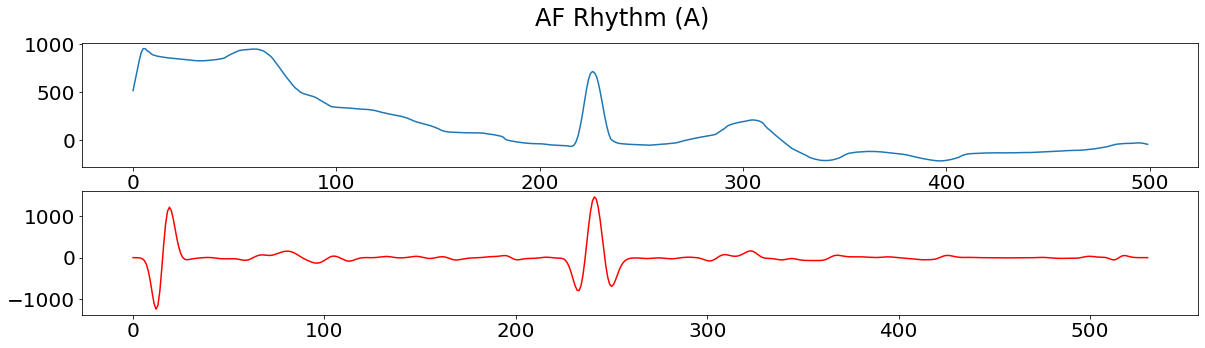

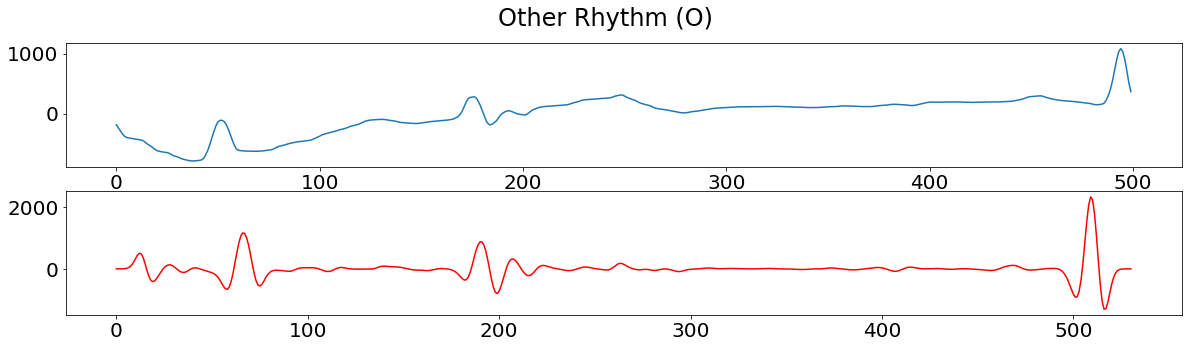

In [ ]:
plt.rcParams['figure.figsize']=(20,5)

signal = df[df["classes"] == 'N'].iloc[0]["signals"][0:500]
fig, ax = plt.subplots(2,1)
fig.suptitle("Sinusal (N)")
z = apply_wavelet(signal, 3)
ax[0].plot(signal)
ax[1].plot(z, 'r')
plt.show()

signal = df[df["classes"] == 'A'].iloc[0]["signals"][0:500]
fig, ax = plt.subplots(2,1)
fig.suptitle("AF Rhythm (A)")
z = apply_wavelet(signal, 3)
ax[0].plot(signal)
ax[1].plot(z, 'r')
plt.show()

signal = df[df["classes"] == 'O'].iloc[0]["signals"][0:500]
fig, ax = plt.subplots(2,1)
fig.suptitle("Other Rhythm (O)")
z = apply_wavelet(signal, 3)
ax[0].plot(signal)
ax[1].plot(z, 'r')
plt.show()

In [ ]:
x = []
for i in df["signals"]:
  val = apply_wavelet(i, 3)
  x.append(val)

In [ ]:
# for i in range(0, len(x)):
#   val = zscore(x[i])
#   x[i] = val

### 2.2 Janelamento dos dados de treino

In [ ]:
intersection = 100
window_size = 500
windows_array = ["max","max","max", "max"]
classes_array = ['N', 'O', 'A', '~']

In [ ]:
def window(signal, intersection, window_size, n):
  s_size = len(signal)
  max_n = (s_size-intersection)/(window_size - intersection)
  samples = []
  
  if  n == "max" or n > max_n:
    n = max_n
    n = math.floor(n)
    
  max_begin = s_size - (n*(window_size) - (n-1)*intersection) + 1
  init = random.randrange(max_begin)
  for i in range(0, n):
    begin = init + i*window_size - i*intersection
    end = begin + window_size
    samples.append(signal[begin:end])

  
  return samples

In [ ]:
def embalance_data(df, classes_array, windows_array, intersection, window_size):

  a = df.groupby('classes')
  d_train = df.copy()
  d_train = d_train.iloc[0:0]


  idx = -1
  for i in classes_array:
    aux = []
    idx += 1

    for index, row in a.get_group(i).iterrows():
      samples = window(row["signals"], intersection, window_size,  windows_array[idx])
      
      for k in range(len(samples)):
        d_train = d_train.append({'signals': samples[k], 'classes': i}, ignore_index=True)

  return d_train

In [ ]:
x_rem, x_test, y_rem, y_test = train_test_split(df["signals"], df["classes"], test_size=0.25)
x_train, x_valid, y_train, y_valid = train_test_split(x_rem, y_rem, test_size=0.1)

d_aux_train = pd.DataFrame({'signals': x_train, 'classes': y_train})
d_train = embalance_data(d_aux_train, classes_array, windows_array, intersection, window_size)

d_aux_valid = pd.DataFrame({'signals': x_valid, 'classes': y_valid})
d_valid = embalance_data(d_aux_valid, classes_array, windows_array, intersection, window_size)

b = d_train.groupby('classes')

for i in ['N','O', 'A', '~']:
  print(i)
  aux = []

  for j in b.get_group(i)["signals"]:
    aux.append(len(j))

  print('Média:', round(np.mean(aux), 2))
  print("Std:", round(np.std(aux), 2))
  print("Qntd:", len(aux))
  print("Min:", min(aux))
  print("---------------")

N
Média: 500.0
Std: 0.0
Qntd: 80176
Min: 500
---------------
O
Média: 500.0
Std: 0.0
Qntd: 40251
Min: 500
---------------
A
Média: 500.0
Std: 0.0
Qntd: 12641
Min: 500
---------------
~
Média: 500.0
Std: 0.0
Qntd: 3544
Min: 500
---------------


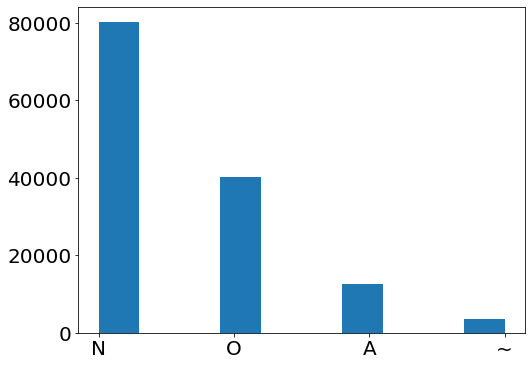

In [ ]:
plt.rcParams.update({'font.size': 20})

d_train["classes"].hist(
    figsize=(8, 6),
    grid = False,
    bins = 10,
)
plt.xticks(range(4))
# plt.savefig('end_distri.png')
plt.show()

###2.4 "Normalização" do tamanho dos sinais

In [ ]:
# for i in range(0, len(x)):
#   val = normalize([x[i]])
#   x[i] = val[0]

#3. Implementação da CNN

##3.1 Descoberta dos hyperparâmetros (Otimização Bayseana)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv1D, MaxPooling1D

from keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl

In [ ]:
y_train = pd.get_dummies(d_train["classes"])
y_valid = pd.get_dummies(d_valid["classes"])

x_train = list(d_train["signals"])
x_valid = list(d_valid["signals"])

x_train = np.array(x_train)
x_valid = np.array(x_valid)
x_test = np.array(x_test)

In [ ]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
# x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], 1)

In [ ]:
# Import packages
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score

pd.set_option("display.max_columns", None)

from sklearn import metrics
import tensorflow as tf

In [ ]:
from keras import backend as K

In [ ]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
score_acc = make_scorer(accuracy_score)

In [ ]:
len(x_train[0])

500

In [ ]:
path_check = 'drive/MyDrive/CNN_Chagas/Physionet/cnn-1d'

In [ ]:
input_shape = len(x_train[0])
k1 = 5
k2 = 3
n = math.floor(input_shape/(k1+k2-2))
nn_input = input_shape % (k1+k2-2)

classificador = Sequential()

for i  in range(0, 5):
  if i == 0:
    classificador.add(Conv1D(filters=32, kernel_size = k1, input_shape = (input_shape, 1), activation = "relu"))
  else:
      classificador.add(Conv1D(filters=32, kernel_size = k1, activation = "relu"))
  # BatchNormalization()
  
  classificador.add(Conv1D(filters=64, kernel_size = k2, activation = "relu"))
  # BatchNormalization()
  # classificador.add(Conv1D(filters=32, kernel_size = k2, activation = "relu"))
  classificador.add(MaxPooling1D(pool_size=2))

classificador.add(Flatten())

classificador.add(Dense(units=64, activation='relu'))
classificador.add(Dense(units=32, activation='relu'))
classificador.add(Dense(units=16, activation='relu'))

classificador.add(Dense(4, activation="softmax"))

classificador.compile(loss='categorical_crossentropy', optimizer=Adamax(learning_rate=0.01), metrics=[f1])

es = EarlyStopping(monitor="f1", mode='max', verbose=0, patience=15)

checkpoint = ModelCheckpoint(path_check + '_pesos_cnn1d.hdf5', monitor="val_f1", verbose=1, 
                                  save_best_only=True, mode='max') 

history = classificador.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=150,
                            batch_size=128, callbacks=[es, checkpoint], verbose=1)



Epoch 1/150
1064/1068 [============================>.] - ETA: 0s - loss: 0.8947 - f1: 0.5827
Epoch 1: val_f1 improved from -inf to 0.63018, saving model to drive/MyDrive/CNN_Chagas/Physionet/cnn-1d_pesos_cnn1d.hdf5
1068/1068 [==============================] - 20s 15ms/step - loss: 0.8944 - f1: 0.5829 - val_loss: 0.7878 - val_f1: 0.6302
Epoch 2/150
1067/1068 [============================>.] - ETA: 0s - loss: 0.7787 - f1: 0.6548
Epoch 2: val_f1 improved from 0.63018 to 0.63833, saving model to drive/MyDrive/CNN_Chagas/Physionet/cnn-1d_pesos_cnn1d.hdf5
1068/1068 [==============================] - 16s 15ms/step - loss: 0.7787 - f1: 0.6548 - val_loss: 0.7807 - val_f1: 0.6383
Epoch 3/150
1067/1068 [============================>.] - ETA: 0s - loss: 0.7509 - f1: 0.6730
Epoch 3: val_f1 improved from 0.63833 to 0.66154, saving model to drive/MyDrive/CNN_Chagas/Physionet/cnn-1d_pesos_cnn1d.hdf5
1068/1068 [==============================] - 16s 15ms/step - loss: 0.7510 - f1: 0.6729 - val_loss: 0.74

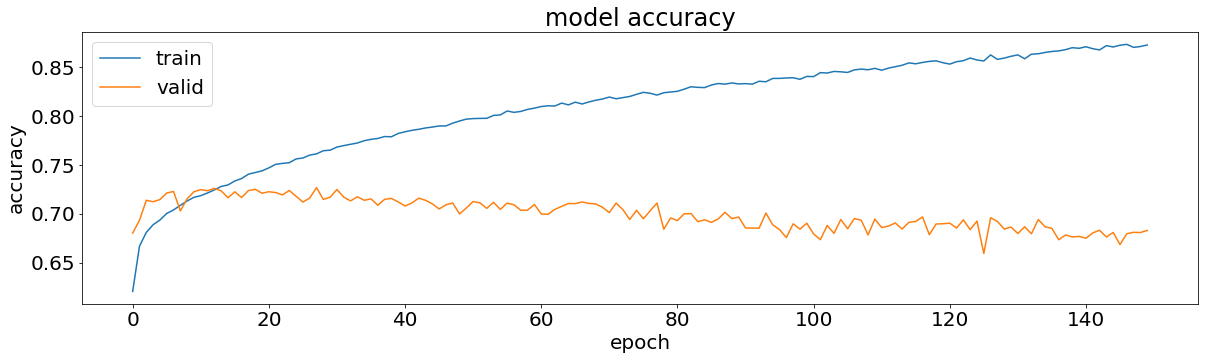

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig("history.png")
plt.show()

In [ ]:
str(type(classificador.layers[0])) == "<class 'keras.layers.convolutional.conv1d.Conv1D'>"

True

In [ ]:
model_weights =[]
for i in classificador.layers:
  layer = "<class 'keras.layers.convolutional.conv1d.Conv1D'>"
  if str(type(i)) == layer:
    model_weights.append(i.get_weights())

In [ ]:
input_shape = len(x_train[0])
k1 = 5
k2 = 3
n = math.floor(input_shape/(k1+k2-2))
nn_input = input_shape % (k1+k2-2)

model = Sequential()

for i  in range(0, 5):
  if i == 0:
    model.add(Conv1D(filters=32, kernel_size = k1, input_shape = (input_shape, 1), activation = "relu"))
  else:
    model.add(Conv1D(filters=32, kernel_size = k1, activation = "relu"))
  
  model.add(Conv1D(filters=64, kernel_size = k2, activation = "relu"))
  model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

In [ ]:
count = 0
for i in model.layers:
  layer = "<class 'keras.layers.convolutional.conv1d.Conv1D'>"
  if str(type(i)) == layer:
    i.set_weights(model_weights[count])
    count += 1

In [ ]:
model.layers[0].get_weights()

[array([[[-1.22025991e-02, -4.33932729e-02,  2.83308867e-02,
          -1.21527247e-01, -3.57059278e-02, -6.46319613e-02,
          -3.26729603e-02,  4.79322001e-02,  1.01570994e-01,
          -5.16819395e-03, -1.17172323e-01,  2.40081325e-02,
          -5.11528403e-02,  3.16567980e-02, -5.09066619e-02,
           2.38624252e-02, -2.21694913e-02, -1.38950171e-02,
          -1.43207726e-03,  3.64796631e-02, -5.75260632e-02,
           1.95063762e-02, -6.38144687e-02,  3.94593924e-02,
           5.21996170e-02, -5.41540124e-02, -7.55723342e-02,
          -4.27225456e-02,  4.41323081e-03, -1.48564903e-03,
          -5.92371710e-02,  3.44173610e-02]],
 
        [[ 5.05209640e-02,  8.53732154e-02, -1.45048931e-01,
          -1.49050742e-01,  9.72217619e-02,  3.87700163e-02,
           5.16169593e-02, -7.15382844e-02, -2.33261257e-01,
           9.07782093e-02,  1.80809408e-01, -6.45604059e-02,
           1.35399401e-02, -1.73567712e-01,  5.10620535e-04,
           1.39030591e-01,  1.3577996

In [ ]:
def pooling(array, type):
  array_size = array.shape[1]
  array_qnt = array.shape[0]
  mp_vector = []

  for j in range(0, array_size):
    aux = []

    for i in range(0, array_qnt):
      aux.append(array[i][j])
      
    if type == "max":
      mp_vector.append(max(aux))

    elif  type == "avg":
      mp_vector.append(np.mean(aux))

  return mp_vector

In [ ]:
def combine_windows(df):

  get_final_output = K.function([model.layers[0].input],
                                  [model.layers[-1].output])

  new_inputs = []

  for element in df["signals"]:
    samples = window(element, intersection, window_size, "max")
    outputs = []

    for sample in samples:
      sample = np.array(list(sample))
      sample = sample.reshape(1, sample.shape[0], 1)
      
      output = get_final_output(sample)
      outputs.append(output)


    outputs = np.array(outputs)
    outputs = outputs.reshape(outputs.shape[0], outputs.shape[-1])

    max_p = pooling(outputs, "max")
    avg_p = pooling(outputs, "avg")
    new_inputs.append(max_p + avg_p)

  return new_inputs


In [ ]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import xgboost as xgb

y_new = d_aux_train["classes"]
y_new = np.array(y_new)

new_inputs = combine_windows(d_aux_train)
new_inputs = np.array(new_inputs)
new_inputs = new_inputs.reshape(new_inputs.shape[0], new_inputs.shape[1])

xgb_cl = xgb.XGBClassifier()
xgb_cl.fit(new_inputs, y_new)

XGBClassifier(objective='multi:softprob')

In [ ]:
valid_inp = combine_windows(d_aux_valid)

y_new_val = d_aux_valid["classes"]
y_new = np.array(y_new_val)

valid_inp = np.array(valid_inp)
valid_inp = valid_inp.reshape(valid_inp.shape[0], valid_inp.shape[1])

y_pred = xgb_cl.predict(valid_inp)

In [ ]:
accuracy_score(y_new_val, y_pred)

0.7859375

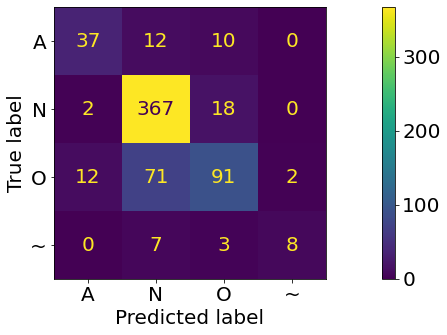

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

cf_matrix = confusion_matrix(y_new_val, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = ['A', 'N', 'O', '~'])
cm_display.plot()
# plt.savefig("test.png")

In [ ]:
from sklearn.metrics import classification_report 
 
relatorio = classification_report(y_new_val, y_pred) 
print(relatorio)

              precision    recall  f1-score   support

           A       0.73      0.63      0.67        59
           N       0.80      0.95      0.87       387
           O       0.75      0.52      0.61       176
           ~       0.80      0.44      0.57        18

    accuracy                           0.79       640
   macro avg       0.77      0.63      0.68       640
weighted avg       0.78      0.79      0.77       640

